**Objective**: Find behaviour patterns in driver activities via clustering. (Manually) Classify this patterns to help recognize common faults while driving.

Example: Frequently missing B_T3 after a B_T2, making the hole sequence illegal.

---

Things worth considering:
- Variable length sequences.
- Activity representation. Possibilities:
  - activity, daytype, sequence, breaktype, token, legal -> [2,0,1,0,1]
  - Not sure if we should consider duration. In that case, should be normalized?
    - Maybe not because we are keeping token, and thus there would be redundant information
- Sequence representation. Possibilities:
  - List of activities (should span a day at most)
  - One activity at a time
  - Just one Sequence
- Distance function depends on the two previous points. Possibilities:
  - Substract duration and for the rest of variables only consider if they are the same. Probably different weights, as legal is more valuable.
- Categorical variables. We need to be careful with the distance function

---

Employed method:
1. Coding activities as word in a list representation
2. Group activities as documents according to the Day column
3. Apply clustering techniques as unsupervised learning

---

Notes:
- K could be bigger than 20 and still coherent. It's important to consider that although there are only ndd/edd/none days, there is an important different in ending in WR, DR...
- D2V: Smaller/bigger vector_size than 200 gives poor results, after a PCA data seems better separated with that vector space (only after normalization, why?). Epochs to 70
- Getting better results with KMeans with cosine distance (via normalization). LDA also gets promising results but topics are more difficult to interpret (due to the lack of ordering and the probabilities)

In [ ]:
# Update gensim to last version
%%capture
!pip install gensim --upgrade

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import normalize

# BOW-TFIDF
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc

# D2V
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import collections

# Clustering
from sklearn.cluster import KMeans

# LDA
from gensim.models import LdaModel
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric

# Visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Silhouette analysis and other clutering metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.cm as cm

# Download data
from google.colab import files

---
## Preprocessing

**TODO**: Try removing top words before transform into BOW o D2V. Most probable activities won't give useful info in clustering as they are present in most clusters. They should differ in ndd or edd, and we probably will be getting better results focusing in Breaks and Rests

Also remove very infrequent words as they would most likely be reffering to Suggestions

In [ ]:
#########################################################################
# Visualize embeddings
#########################################################################

def plot_tsne(matrix, clusters=None, ax=None):
  ax = ax or plt.gca()

  # TSNE
  tsne = TSNE(n_components=2, random_state=12345)
  X_tsne = tsne.fit_transform(matrix)
  df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])

  ax.scatter(df_tsne['x'], df_tsne['y'], alpha=0.5, c=clusters)
  ax.set_title('TSNE')

# -------------------------------------------------------------------------

def plot_pca(matrix, clusters=None, ax=None):
  ax = ax or plt.gca()

  # PCA
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(matrix)
  df_pca = pd.DataFrame(X_pca, columns=['x', 'y'])

  ax.scatter(df_pca['x'], df_pca['y'], alpha=0.5, c=clusters)
  ax.set_title('2D PCA')
  
# -------------------------------------------------------------------------

def plot_3d_pca(matrix, clusters=None, ax=None):
  ax = ax or plt.gca()

  # PCA
  pca = PCA(n_components=3)
  X_pca = pca.fit_transform(matrix)
  df_pca = pd.DataFrame(X_pca, columns=['x', 'y', 'z'])

  ax.scatter3D(df_pca['x'], df_pca['y'], df_pca['z'], alpha=0.5, c=clusters)
  ax.set_title('3D PCA')

# -------------------------------------------------------------------------

# Call the three functions above in a horizontal view
def visualize_data(matrix, model_name, clusters=None, ax1=None, ax2=None):
  fig = plt.figure(figsize=(27,6))
  fig.suptitle('{} document plots'.format(model_name))

  ax1 = fig.add_subplot(131)
  ax2 = fig.add_subplot(132)
  ax3 = fig.add_subplot(133, projection='3d')

  plot_tsne(matrix, ax=ax1, clusters=clusters)
  plot_pca(matrix, ax=ax2, clusters=clusters)
  plot_3d_pca(matrix, ax=ax3, clusters=clusters)

  plt.show()

---

In [10]:
#########################################################################
# Load data
#########################################################################
data_path = "./combined-log.csv"
df = pd.read_csv(data_path, sep="\t",)

# To timestamp format
df.DateTimeStart = pd.to_datetime(df.DateTimeStart)
df.DateTimeEnd = pd.to_datetime(df.DateTimeEnd)

# Rename column
df = df_original = df.rename(columns={"#Driver":"Driver", "Duration(min)":"Duration"})


# To numerical
df.Legal = df.Legal.map({"yes": 1, "no": 0}) # Not sure if [-1,1] is better

# Drop columns
df = df.drop(columns=['Duration', 'ZenoInfo', "DateTimeStart", "DateTimeEnd", 'Week'])

df

,Driver,Activity,Day,DayType,Sequence,BreakType,Token,Legal
0,driver1,Break,1.0,ndd,first,split_1,B_T0,1
1,driver1,Driving,1.0,ndd,first,split_1,A,1
2,driver1,Other,1.0,ndd,first,split_1,A,1
3,driver1,Driving,1.0,ndd,first,split_1,A,1
4,driver1,Other,1.0,ndd,first,split_1,A,1
...,...,...,...,...,...,...,...,...
27163,driver188,Break,11.0,ndd,unique,uninterrupted,DR_T3,1
27164,driver188,Idle,12.0,ndd,unique,uninterrupted,I,1
27165,driver188,Break,12.0,ndd,unique,uninterrupted,B_T0,1
27166,driver188,Idle,12.0,ndd,unique,uninterrupted,I,1


In [11]:
#########################################################################
# Transform data
# Encode each column as numeric and group them
#########################################################################

# The encoded columns are:
# Activity - DayType - Sequence - BreakType - Token - Legal

# Reorder columns
cols = ['Driver', 'Day', 'Activity', 'DayType', 'Sequence', 'BreakType', 'Token', 'Legal']
df = df[cols]

x = df.to_numpy()

# Encode into ordinal numbers
ordinalencoder_X = OrdinalEncoder(dtype=np.int8)
x[:,2:] = ordinalencoder_X.fit_transform(x[:,2:])

df_encoded = pd.DataFrame(x, columns=cols)

# Group columns into one (as string)
df_encoded['Encoding'] = df_encoded[df_encoded.columns[2:]].apply(
                            lambda x: '-'.join(x.dropna().astype(str)),
                            axis=1
                        )

# Remove encoded columns
df_encoded = df_encoded[['Driver','Day','Encoding']]

df_encoded

,Driver,Day,Encoding
0,driver1,1,0-1-0-1-1-1
1,driver1,1,1-1-0-1-0-1
2,driver1,1,3-1-0-1-0-1
3,driver1,1,1-1-0-1-0-1
4,driver1,1,3-1-0-1-0-1
...,...,...,...
27163,driver188,11,0-1-4-3-7-1
27164,driver188,12,2-1-4-3-9-1
27165,driver188,12,0-1-4-3-1-1
27166,driver188,12,2-1-4-3-9-1


In [12]:
# Group activities by day and join them in a list

# For each driver append all Encodings of one Day into a list
groups = df_encoded.groupby('Driver', sort=False) # False to keep driver ordering

# Each sentence is the sequence of activities in a day
corpus_lists = []

for name, group in groups:
  a = group.drop(columns='Driver')
  g = a.groupby('Day').cumcount()
  L = (a.set_index(['Day',g])
        .stack().groupby(level=0)
        .apply(lambda x: x.values))

  corpus_lists.extend(L)

In [13]:
print("Number of unique sequences (activities): {}".format(len(df_encoded.Encoding.unique())))
# df_encoded.Encoding.unique()

Number of unique sequences (activities): 152


---
- Word: Encoded activity
- Document: Words for a day (no matter the week or the driver)
---

In [149]:
#########################################################################
# Get embeddings
# Bag-of-words and TF-IDF
# 
# It seem it will work without considering order (maybe because the tags already
# add information about it?)
# 
# https://stackoverflow.com/questions/50933591/how-to-perform-kmean-clustering-from-gensim-tfidf-values
#########################################################################

# Get the dictionary of our corpus
dictionary = Dictionary(corpus_lists)
num_docs = dictionary.num_docs
num_terms = len(dictionary.keys())

# Filter out words that occur less than 20% documents, or more than 70% of the documents.
dictionary.filter_extremes(no_below=0.2, no_above=0.7)

# Transform into bow (bag-of-words)
# It's a small dictionary so I think this representation shouldn't be a problem
corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_lists]

# Transform into tf-idf (term frequency – inverse document frequency)
tfidf = TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

# Transform into sparse/dense matrix:
corpus_tfidf_dense = corpus2dense(corpus_tfidf, num_terms, num_docs).T   # Transposed!

---

In [180]:
#########################################################################
# Get embeddings
# Paragraph Vector (Doc2Vec)
# Word2vec for all the documents
# https://stats.stackexchange.com/questions/347563/how-to-improve-doc2vec-model
#########################################################################

# Tag documents
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_lists)]

# Define and initialize model
doc2vec = Doc2Vec(documents, 
                  vector_size=200, 
                  epochs=70,
                  min_count=len(corpus_lists) * 0.2, # Lower than 20%. Previously 20 words
                  # alpha=0.05,
                  # min_alpha=0.01,
                  seed=12345)

# Train model
doc2vec.train(documents, 
              total_examples=doc2vec.corpus_count, 
              epochs=doc2vec.epochs)

In [76]:
# Evaluate doc2vec model

ranks = []
second_ranks = []
for doc_id in range(len(documents)):
    inferred_vector = doc2vec.infer_vector(documents[doc_id].words)
    sims = doc2vec.dv.most_similar([inferred_vector], topn=len(doc2vec.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [77]:
counter = collections.Counter(ranks)

print("Number of documents: {}".format(len(documents)))
print(counter)
print("Inferred documents similar to itself: {}%".format(round(counter[0]/len(documents) * 100,2)))

Number of documents: 1694
Counter({0: 523, 1: 176, 2: 94, 3: 68, 4: 54, 5: 48, 6: 31, 9: 30, 8: 28, 14: 24, 12: 23, 7: 22, 10: 22, 11: 21, 13: 20, 19: 19, 20: 17, 17: 16, 15: 16, 33: 11, 16: 10, 27: 10, 18: 10, 23: 8, 31: 8, 40: 8, 39: 8, 30: 7, 66: 7, 54: 7, 35: 7, 21: 7, 26: 7, 22: 7, 57: 7, 25: 6, 42: 6, 41: 6, 47: 5, 49: 5, 29: 5, 38: 5, 63: 5, 53: 5, 46: 4, 36: 4, 37: 4, 70: 4, 55: 4, 51: 4, 68: 4, 161: 4, 56: 4, 52: 4, 129: 3, 106: 3, 24: 3, 34: 3, 74: 3, 28: 3, 88: 3, 93: 3, 44: 3, 110: 3, 62: 3, 60: 3, 160: 3, 83: 3, 109: 3, 118: 3, 190: 3, 90: 3, 45: 3, 162: 3, 159: 2, 97: 2, 43: 2, 193: 2, 85: 2, 86: 2, 80: 2, 125: 2, 120: 2, 111: 2, 69: 2, 77: 2, 151: 2, 182: 2, 50: 2, 87: 2, 78: 2, 145: 2, 76: 2, 114: 2, 134: 2, 32: 2, 155: 2, 169: 2, 115: 2, 128: 2, 1692: 2, 108: 2, 64: 2, 48: 2, 136: 2, 65: 2, 105: 2, 164: 2, 58: 2, 91: 2, 150: 1, 478: 1, 199: 1, 1685: 1, 147: 1, 214: 1, 99: 1, 130: 1, 146: 1, 142: 1, 72: 1, 1173: 1, 100: 1, 103: 1, 126: 1, 531: 1, 701: 1, 991: 1, 158: 1,

In [181]:
# Get embedding for each document
embeddings_d2v = []

for sentence in corpus_lists:
  embeddings_d2v.append(
      doc2vec.infer_vector(sentence)
  )

In [182]:
# Renaming document data for consistent nomenclature during training
X_bow = corpus_tfidf_dense
X_d2v = embeddings_d2v

---

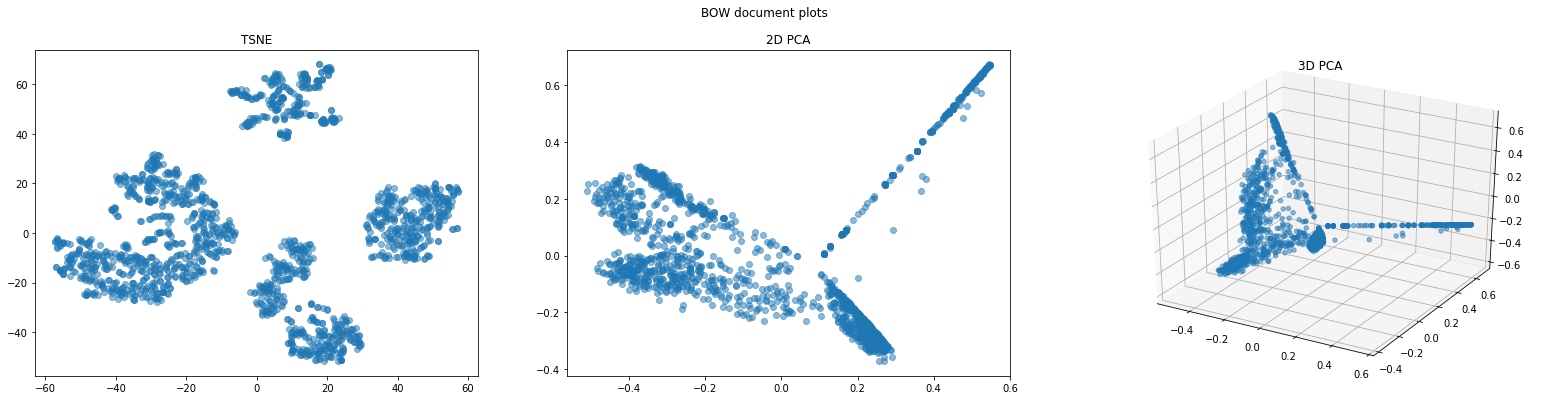

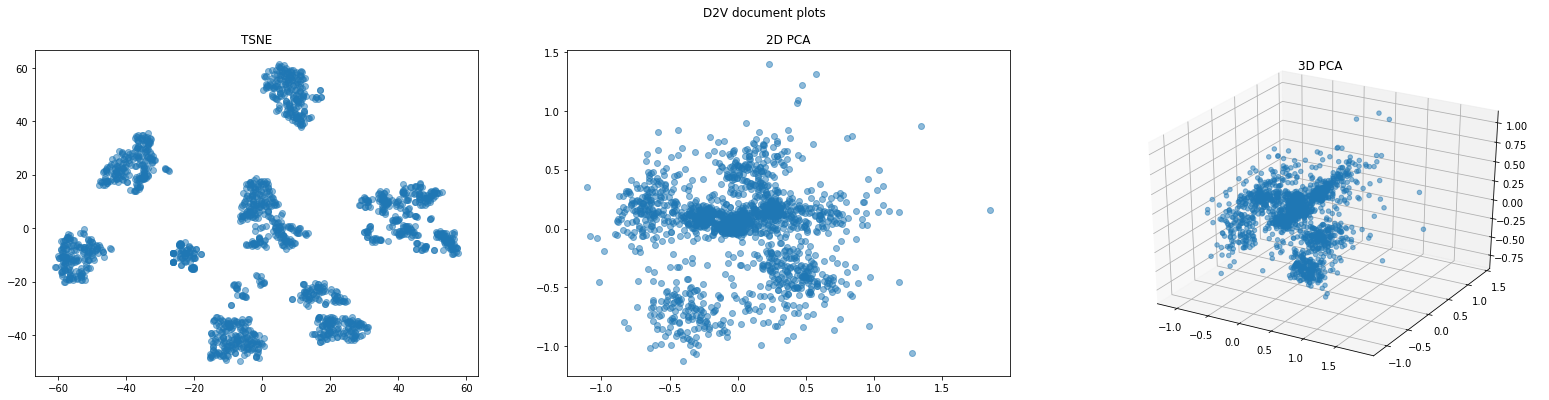

In [151]:
visualize_data(X_bow, 'BOW')
visualize_data(X_d2v, 'D2V')

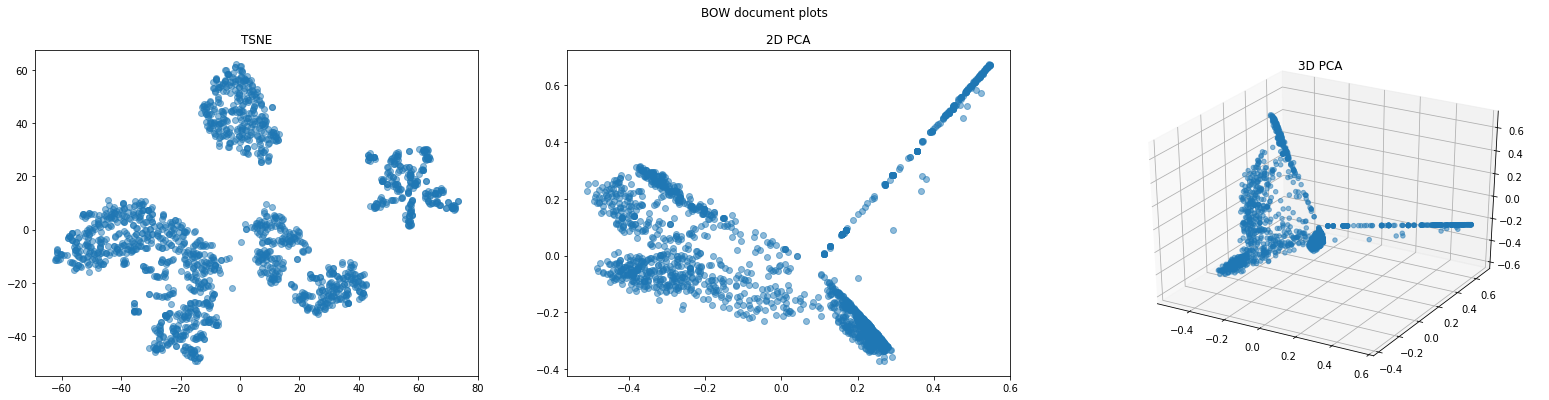

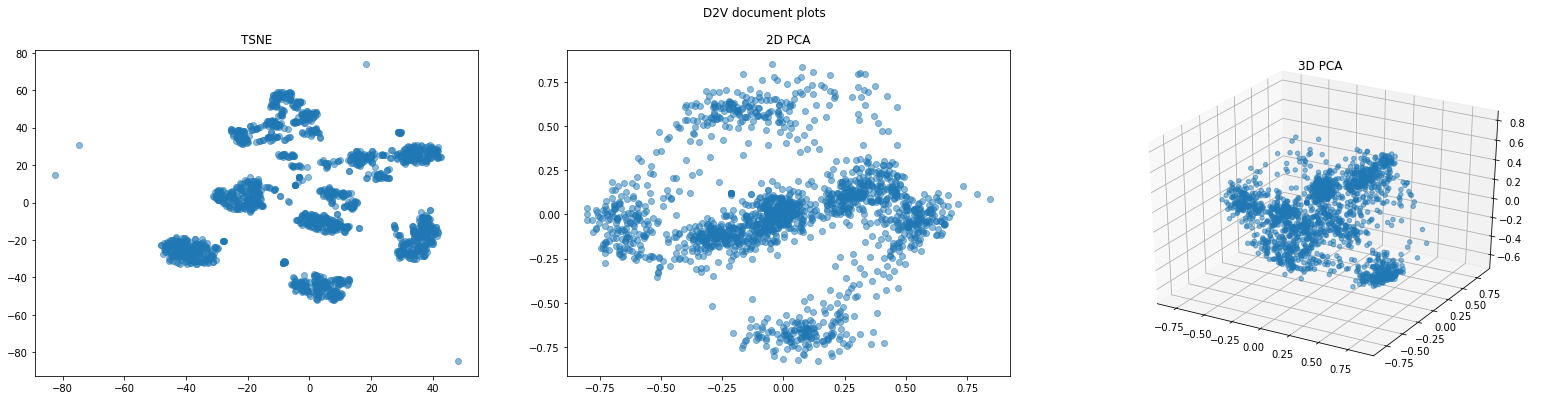

In [183]:
# Normalize data (To use cosine distance instead of euclidean)
# CAREFULL: KMEANS AND LDA NOT AFFECTED, BUT OTHERS METHODS COULD BE
# https://datascience.stackexchange.com/questions/6715/is-it-necessary-to-standardize-your-data-before-clustering

X_bow = normalize(X_bow)
X_d2v = normalize(X_d2v)

visualize_data(X_bow, 'BOW')
visualize_data(X_d2v, 'D2V')

Apparently not a good dataset for clustering. High density and not clear partitions (although it must be noted that we are visualizing 2 dimensions from >100)

---
## K-MEANS

KMeans assumes that clusters are convex shaped (in order to calculate the proper centroids). I'm not sure if our data takes this shape, but I'll try this method and compare it with others

In [111]:
#########################################################################
# Showing metrics for different K values in K-means
# https://stackoverflow.com/questions/65991074/how-to-find-most-optimal-number-of-clusters-with-k-means-clustering-in-python
#########################################################################

def kmeans_k_tuning(X, lower_k=20, upper_k=30, plot=True):
  fitted_kmeans = {}
  labels_kmeans = {}
  df_scores = []
  k_values_to_try = np.arange(lower_k, upper_k)

  for n_clusters in k_values_to_try:
      
      # Perform clustering
      kmeans = KMeans(n_clusters=n_clusters, random_state=12345)
      labels_clusters = kmeans.fit_predict(X)
      
      # Insert fitted model and calculated cluster labels in dictionaries,
      # for further reference
      fitted_kmeans[n_clusters] = kmeans
      labels_kmeans[n_clusters] = labels_clusters
      
      # Calculate various scores, and save them for further reference.
      silhouette = silhouette_score(X, labels_clusters)
      ch = calinski_harabasz_score(X, labels_clusters)
      db = davies_bouldin_score(X, labels_clusters)
      tmp_scores = {"n_clusters": n_clusters,
                    "silhouette_score": silhouette,
                    "calinski_harabasz_score": ch,
                    "davies_bouldin_score": db,
                    }
      df_scores.append(tmp_scores)

      #-------------------------------------------------------------------------
      # Plot silhouette

      # Create a subplot with 1 row and 2 columns
      if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(30, 10)

        colors = cm.nipy_spectral(labels_clusters.astype(float) / n_clusters)

        plot_silhouette(X, n_clusters, labels_clusters, ax1)
        plot_tsne(X, clusters=colors, ax=ax2)
        plot_pca(X, clusters=colors, ax=ax3)

        plt.suptitle(
            "Silhouette analysis for KMeans clustering with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

        plt.show()


  #Create a DataFrame of clustering scores, using `n_clusters` as index, for easier plotting.
  df_scores = pd.DataFrame(df_scores)
  df_scores.set_index("n_clusters", inplace=True)

  return df_scores, fitted_kmeans, labels_kmeans

---

In [184]:
#########################################################################
# Train data
# KMeans clustering (Euclidean distance)
#########################################################################

# Apply KMeans clustering
kmeans = KMeans(n_clusters=25, random_state=12345)

clusters_bow = kmeans.fit_predict(X_bow)
centroid_bow = kmeans.cluster_centers_

kmeans = KMeans(n_clusters=25, random_state=12345)

clusters_d2v = kmeans.fit_predict(X_d2v)
centroid_d2v = kmeans.cluster_centers_

In [185]:
print("Mean Silhouette Coefficient - BOW: %0.3f" % silhouette_score(X_bow, clusters_bow))
print("Mean Silhouette Coefficient - D2V: %0.3f" % silhouette_score(X_d2v, clusters_d2v))

Mean Silhouette Coefficient - BOW: 0.152
Mean Silhouette Coefficient - D2V: 0.349


https://jmlr.csail.mit.edu/papers/volume17/15-627/15-627:

- Use ARI when the ground truth clustering has large equal sized clusters
- Use AMI when the ground truth clustering is unbalanced and there exist small cluster

Showing both, but focusing in AMI

In [109]:
print("Adjusted Rand Index:         {}".format(adjusted_rand_score(clusters_bow, clusters_d2v)))
print("Adjusted Mutual Information: {}".format(adjusted_mutual_info_score(clusters_bow, clusters_d2v)))

Adjusted Rand Index:         0.4299885452251121
Adjusted Mutual Information: 0.6462411880792235


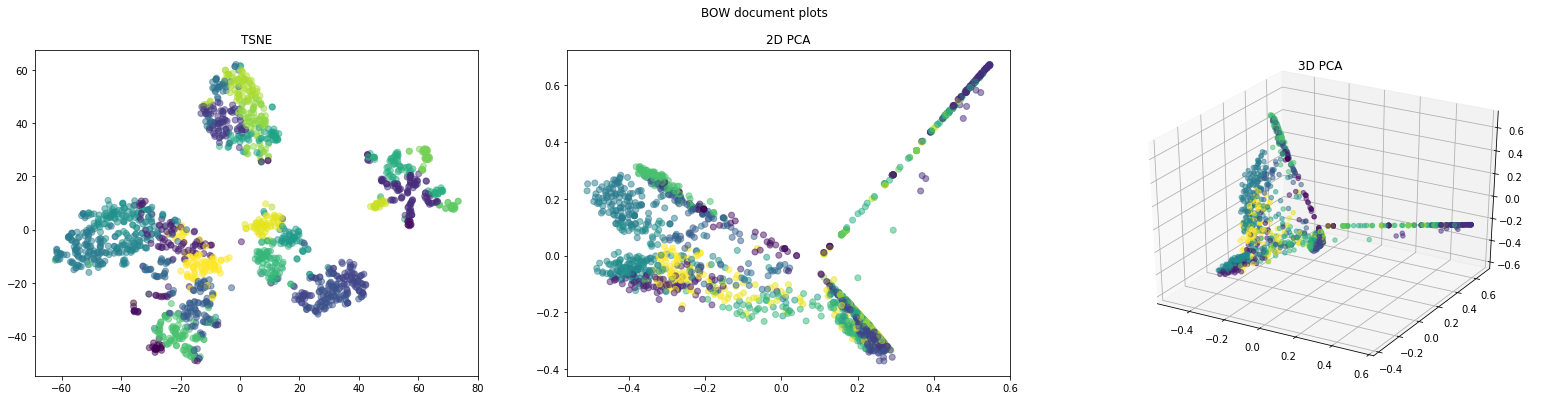

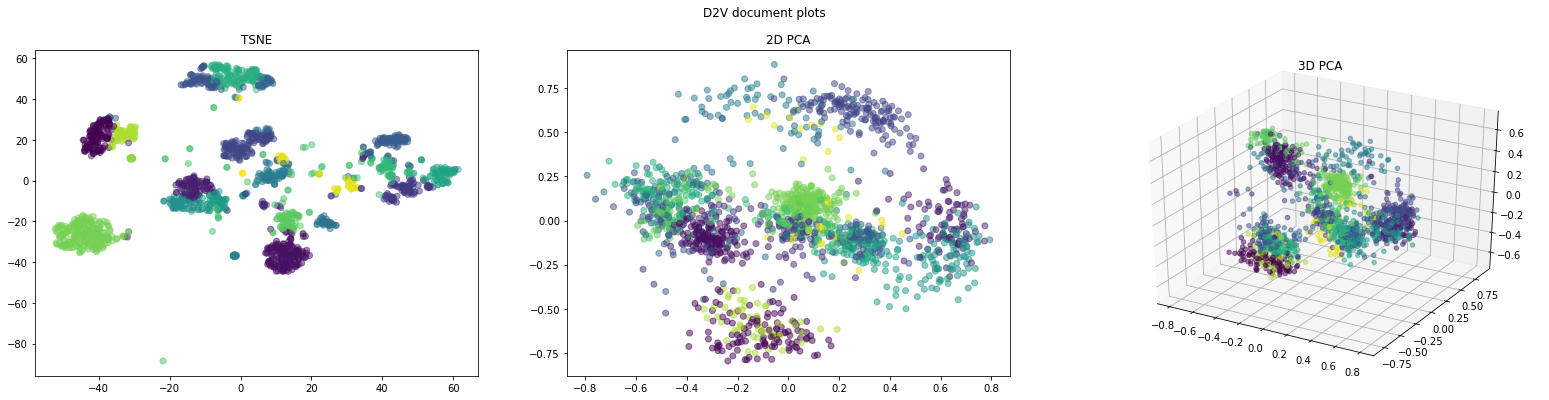

In [110]:
#########################################################################
# Plot clustered data
#########################################################################

visualize_data(X_bow, 'BOW', clusters_bow)
visualize_data(X_d2v, 'D2V', clusters_d2v)

## K analysis for KMeans


In [ ]:
#########################################################################
# Silhouette analysis
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
#########################################################################

def plot_silhouette(X, n_clusters, cluster_labels, ax=None):
  ax = ax or plt.gca()

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1
  ax.set_xlim([-0.2, 1])

  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed clusters
  silhouette_avg = silhouette_score(X, cluster_labels)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(X, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

  ax.set_title("Silhouette plot for the various clusters: {}".format(round(silhouette_avg,3)))
  ax.set_xlabel("Silhouette coefficient values")
  ax.set_ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  ax.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax.set_yticks([])  # Clear the yaxis labels / ticks

  xticks = [-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
  ax.set_xticks(xticks)
  ax.set_xticklabels(xticks, rotation=40)

# ------------------------------------------------------------------------------

# Plot Silhouette graph for KMeans with the specified n_clusters
def silhouette_analysis(X, range_n_clusters):

  for n_clusters in range_n_clusters:
      # Create a subplot with 1 row and 2 columns
      fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
      fig.set_size_inches(30, 10)

      # Initialize the clusterer with n_clusters value and a random generator
      clusterer = KMeans(n_clusters=n_clusters, random_state=12345)
      cluster_labels = clusterer.fit_predict(X)

      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

      plot_silhouette(X, n_clusters, cluster_labels, ax1)
      plot_tsne(X, clusters=colors, ax=ax2)
      plot_pca(X, clusters=colors, ax=ax3)

      plt.suptitle(
          "Silhouette analysis for KMeans clustering with n_clusters = %d"
          % n_clusters,
          fontsize=14,
          fontweight="bold",
      )

  plt.show()

### Silhouette Coefficient
If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:

s = (b-a) / max(a,b) 

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.

#### Advantages
- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

#### Drawbacks
- The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

### Calinski-Harabasz Index
If the ground truth labels are not known, the Calinski-Harabasz index (sklearn.metrics.calinski_harabasz_score) - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

#### Advantages
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
- The score is fast to compute.

#### Drawbacks
- The Calinski-Harabasz index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

### Davies-Bouldin Index
If the ground truth labels are not known, the Davies-Bouldin index (sklearn.metrics.davies_bouldin_score) can be used to evaluate the model, where a lower Davies-Bouldin index relates to a model with better separation between the clusters.

This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

Zero is the lowest possible score. Values closer to zero indicate a better partition.

#### Advantages
- The computation of Davies-Bouldin is simpler than that of Silhouette scores.
- The index is solely based on quantities and features inherent to the dataset as its computation only uses point-wise distances.

#### Drawbacks
- The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCAN.
- The usage of centroid distance limits the distance metric to Euclidean space.

In [179]:
bow_df_scores, bow_fitted_kmeans, bow_labels_kmeans = kmeans_k_tuning(X_bow, plot=False)
bow_df_scores

,silhouette_score,calinski_harabasz_score,davies_bouldin_score
n_clusters,,,
20,0.142012,85.698513,2.148892
21,0.146440,85.471310,2.038888
22,0.144751,83.199007,2.044478
23,0.139534,81.028166,2.098436
24,0.141089,79.546967,2.020376
25,0.151541,77.983050,1.980219
26,0.148084,75.865190,1.983578
27,0.154211,75.580961,1.997277
28,0.147706,74.133487,1.956887


Given the large number of days in our dataset I'm not fond to believe that a small number of clusters (< 15) is a good value.

Although it may seem to have better defined clusters (good silhouette and calinski values) I would consider that number only if we aim to get the smallest possible number of clusters.


Silhouette and Davies scores start to increase at 24 but past 30 could be an excessive quantity.

**Overall not a good partition with any number, but considering how awfully distributed is our data I don't think we can expect much better results**

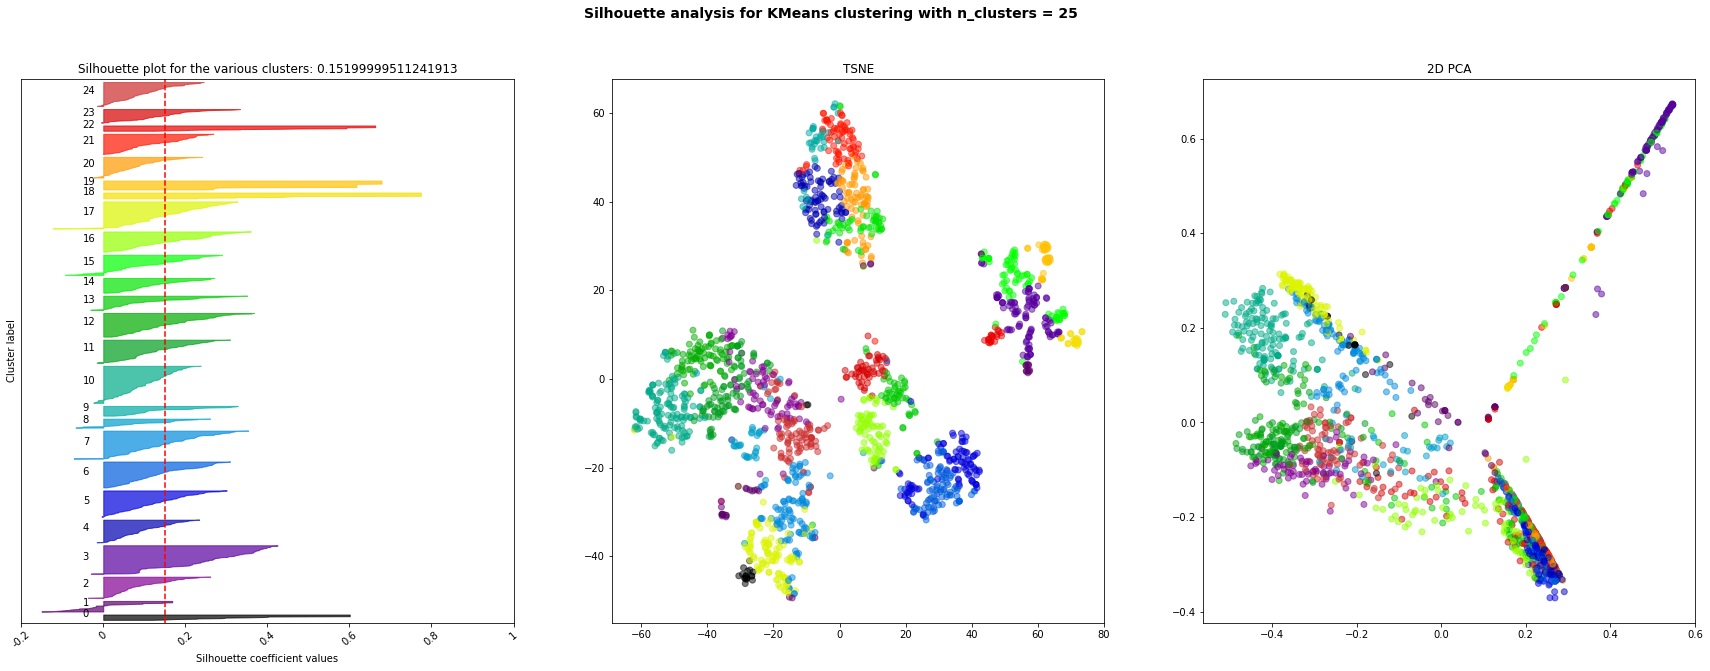

In [115]:
range_n_clusters = [25]
silhouette_analysis(X_bow, range_n_clusters)

In [113]:
d2v_df_scores, d2v_fitted_kmeans, d2v_labels_kmeans = kmeans_k_tuning(X_d2v, plot=False)
d2v_df_scores

,silhouette_score,calinski_harabasz_score,davies_bouldin_score
n_clusters,,,
20,0.343726,245.822715,1.487513
21,0.345114,237.437432,1.523454
22,0.333689,239.219296,1.499463
23,0.346478,231.449303,1.417418
24,0.343998,226.809514,1.424534
25,0.350554,222.587193,1.500010
26,0.333618,220.796547,1.475659
27,0.336631,218.306196,1.531227
28,0.342768,215.054980,1.520412


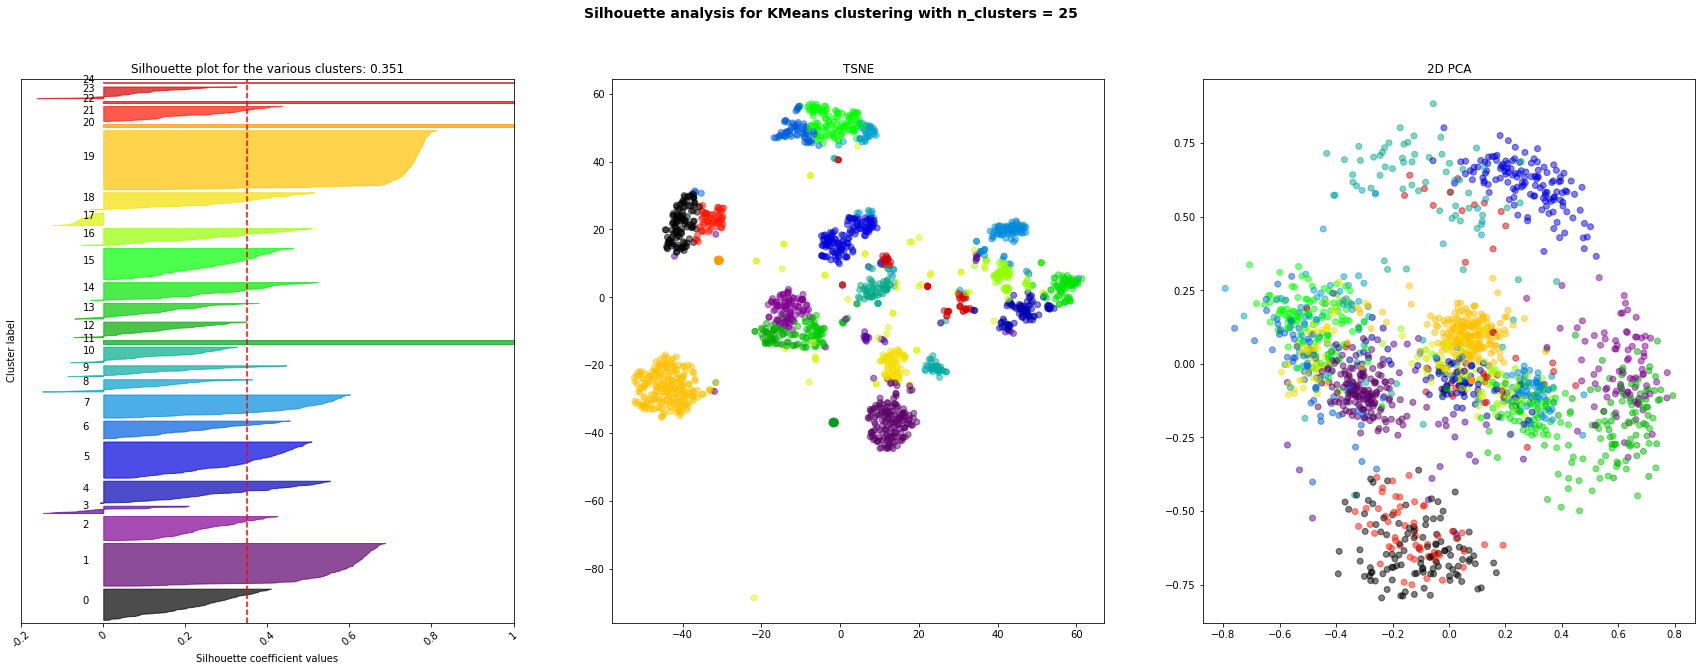

In [114]:
range_n_clusters = [25]
silhouette_analysis(X_d2v, range_n_clusters)

---
### Save KMeans results

In [9]:
#########################################################################
# Get decoded centroids for Doc2Vec
#########################################################################

# Receives an encoding: String 'x-x-x-x-x-x'
def undo_encoding(x):
  l = x.split('-')
  return [int(e) for e in l]

# Receives a document (n_activities, 1)
def v_undo_encoding(x):
  return [undo_encoding(e) for e in x]

# ------------------------------------------------------------------------------

# If an embedded document is (n_samples, n_variables)
# Expects shape: (n_clusters, n_variables)
def get_decoded_centroids_d2v(centroids):
  # For each centroid get the most similar document
  centroid_docs = []
  for cent in centroids:
    doc, similarity = doc2vec.dv.most_similar(positive = [cent], topn=1)[0]
    centroid_docs.append(doc)

  # Get the content of each doc
  docs = []
  for c_doc in centroid_docs:
    docs.append(corpus_lists[c_doc])

  # -----------------------------------------------

  # Get input format for inverse_encoder
  encoded_centroids = list(map(v_undo_encoding, docs))

  # Decode each centroid
  decoded_centroids = []
  for centroid in encoded_centroids:
    # Expects list(list(decoded_activity))
    # e.g: [[1, 1, 4, 3, 0, 1], [3, 1, 4, 3, 0, 1]]
    b = ordinalencoder_X.inverse_transform(centroid)
    
    decoded_centroids.append(b)

  # -----------------------------------------------
  # Get centroids as DataFrame

  cols = ['Activity', 'DayType', 'Sequence', 'BreakType', 'Token', 'Legal']

  df_centroids = pd.DataFrame(columns=cols)

  for c, number in zip(decoded_centroids, range(len(decoded_centroids))):
    df_c = pd.DataFrame(c, columns=cols)
    df_c["Cluster"] = number

    df_centroids = df_centroids.append(df_c)

  return df_centroids

---

In [124]:
selected_k = 25

In [125]:
#########################################################################
# Get decoded centroids for Doc2Vec
#########################################################################

centroid_d2v = d2v_fitted_kmeans[selected_k].cluster_centers_

decoded_centroids_d2v = get_decoded_centroids_d2v(centroid_d2v)
decoded_centroids_d2v

,Activity,DayType,Sequence,BreakType,Token,Legal,Cluster
0,Driving,ndd,first,uninterrupted,A,1,0.0
1,Break,ndd,first,uninterrupted,B_T0,1,0.0
2,Driving,ndd,first,uninterrupted,A,1,0.0
3,Other,ndd,first,uninterrupted,A,1,0.0
4,Break,ndd,first,uninterrupted,B_T1,1,0.0
...,...,...,...,...,...,...,...
14,Driving,ndd,first,split_2,A,1,24.0
15,Break,ndd,first,split_2,B_T0,1,24.0
16,Other,ndd,first,split_2,A,1,24.0
17,Break,ndd,first,split_2,B_T3,1,24.0


In [ ]:
# Print results in human-readable mode

# NOTE: Select here which clusters show
clusters = d2v_labels_kmeans[selected_k]

groups = df2.groupby(['Driver','Day'], sort=False)

results = []
for (name, group), cluster in zip(groups, clusters):
  results.append("{} in day {}: {}".format(name[0], int(name[1]), cluster))

results

In [187]:
#########################################################################
# Save results
#########################################################################

# NOTE: Select here which clusters save
clusters = bow_labels_kmeans[selected_k]
# clusters = d2v_labels_kmeans[selected_k]

# Final dataset columns
cols = df_original.columns.to_numpy()
cols = np.insert(cols, -1, 'Cluster')

df_out = pd.DataFrame(columns=cols)

groups = df_original.groupby(['Driver','Day'], sort=False)

# Add clusters to log
for (name, group), cluster in zip(groups, clusters):
  group["Cluster"] = cluster
  df_out = df_out.append(group)

df_out

,Driver,DateTimeStart,DateTimeEnd,Duration,Activity,Week,Day,DayType,Sequence,BreakType,Token,Legal,Cluster,ZenoInfo
0,driver1,2017-02-01 17:59:00,2017-02-01 18:13:00,14.0,Break,1.0,1.0,ndd,first,split_1,B_T0,1,24,NaN
1,driver1,2017-02-01 18:13:00,2017-02-01 18:16:00,3.0,Driving,1.0,1.0,ndd,first,split_1,A,1,24,NaN
2,driver1,2017-02-01 18:16:00,2017-02-01 18:18:00,2.0,Other,1.0,1.0,ndd,first,split_1,A,1,24,NaN
3,driver1,2017-02-01 18:18:00,2017-02-01 18:20:00,2.0,Driving,1.0,1.0,ndd,first,split_1,A,1,24,NaN
4,driver1,2017-02-01 18:20:00,2017-02-01 18:43:00,23.0,Other,1.0,1.0,ndd,first,split_1,A,1,24,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27163,driver188,2017-01-15 03:30:00,2017-01-15 08:22:00,292.0,Break,4.0,11.0,ndd,unique,uninterrupted,DR_T3,1,18,NaN
27164,driver188,2017-01-15 08:22:00,2017-01-15 08:32:00,10.0,Idle,4.0,12.0,ndd,unique,uninterrupted,I,1,15,NaN
27165,driver188,2017-01-15 08:32:00,2017-01-15 08:37:00,5.0,Break,4.0,12.0,ndd,unique,uninterrupted,B_T0,1,15,NaN
27166,driver188,2017-01-15 08:37:00,2017-01-15 08:54:00,17.0,Idle,4.0,12.0,ndd,unique,uninterrupted,I,1,15,NaN


In [188]:
!mkdir results

# Save as CSV
df_out.to_csv("results/log-clustering.csv", sep="\t", index=False)

# Save each cluster separated
groups = df_out.groupby(['Cluster'], sort=False)

# Add clusters to log
for name, group in groups:
  cluster = group['Cluster'].to_numpy()[0]
  
  path = "results/log-clustering-c{}.csv".format(cluster)
  group.to_csv(path, sep="\t", index=False)

In [128]:
# Save d2v centroids
decoded_centroids_d2v.to_csv("results/log-clustering-centroids.csv", sep="\t", index=False)

---
## DBSCAN

In [ ]:
#########################################################################
# Showing metrics for different distance values in DBscan
# https://stackoverflow.com/questions/65991074/how-to-find-most-optimal-number-of-clusters-with-k-means-clustering-in-python
#########################################################################

def dbscan_eps_tuning(X, lower_eps=0.1, upper_eps=1.1, plot=True):
  fitted_dbscan = {}
  labels_dbscan = {}
  df_scores = []
  eps_values_to_try = np.arange(lower_eps, upper_eps, 0.1)

  for eps in eps_values_to_try:
      
      # Perform clustering
      dbscan = DBSCAN(eps=eps, min_samples=20)
      labels_clusters = dbscan.fit_predict(X)
      # centroid_d2v = dbscan.core_sample_indices_
      
      # Insert fitted model and calculated cluster labels in dictionaries,
      # for further reference
      fitted_dbscan[eps] = dbscan
      labels_dbscan[eps] = labels_clusters
      
      # Calculate various scores, and save them for further reference.
      n_clusters = len(np.unique(labels_clusters))

      if n_clusters > 1:
        silhouette = silhouette_score(X, labels_clusters)
        ch = calinski_harabasz_score(X, labels_clusters)
        db = davies_bouldin_score(X, labels_clusters)
      else:
        silhouette = ch = db = 0

      tmp_scores = {"EPS value": eps,
                    "n_clusters": n_clusters,
                    "silhouette_score": silhouette,
                    "calinski_harabasz_score": ch,
                    "davies_bouldin_score": db,
                    }
      df_scores.append(tmp_scores)

      #-------------------------------------------------------------------------
      # Plot silhouette

      # Create a subplot with 1 row and 2 columns
      if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(30, 10)

        colors = cm.nipy_spectral(labels_clusters.astype(float) / n_clusters)

        plot_silhouette(X, n_clusters, labels_clusters, ax1)
        plot_tsne(X, clusters=colors, ax=ax2)
        plot_pca(X, clusters=colors, ax=ax3)

        plt.suptitle(
            "Silhouette analysis for KMeans clustering with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

        plt.show()


  #Create a DataFrame of clustering scores, using `n_clusters` as index, for easier plotting.
  df_scores = pd.DataFrame(df_scores)
  df_scores.set_index("EPS value", inplace=True)

  return df_scores, fitted_dbscan, labels_dbscan

---

In [ ]:
#########################################################################
# Train data
# DBscan clustering
#########################################################################

# The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. 
# Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped.
# https://scikit-learn.org/stable/modules/clustering.html#dbscan

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.7,
                min_samples=10)
clusters_bow = dbscan.fit_predict(X_bow)
centroid_bow = dbscan.core_sample_indices_

dbscan = DBSCAN(eps=0.7,
                min_samples=10)
clusters_d2v = dbscan.fit_predict(X_d2v)
centroid_d2v = dbscan.core_sample_indices_

# Cluster = -1 -> Noise

In [ ]:
print("Mean Silhouette Coefficient [BOW]: %0.3f" % silhouette_score(X_bow, clusters_bow))
print(np.unique(clusters_bow))
print("Mean Silhouette Coefficient [D2V]: %0.3f" % silhouette_score(X_d2v, clusters_d2v))
print(np.unique(clusters_d2v))

Mean Silhouette Coefficient [BOW]: 0.099
[-1  0  1  2  3  4  5  6]
Mean Silhouette Coefficient [D2V]: 0.148
[-1  0]


In [ ]:
bow_df_scores, bow_fitted_dbscan, bow_labels_dbscan = dbscan_eps_tuning(X_bow, plot=False)
bow_df_scores

,n_clusters,silhouette_score,calinski_harabasz_score,davies_bouldin_score
EPS value,,,,
0.1,1,0.000000,0.000000,0.000000
0.2,1,0.000000,0.000000,0.000000
0.3,1,0.000000,0.000000,0.000000
0.4,2,0.058134,88.205041,1.554260
0.5,4,0.011216,58.008154,1.666083
0.6,5,0.047931,82.846565,2.364285
0.7,5,0.112693,108.054015,2.533096
0.8,4,0.102754,95.580885,3.936324
0.9,2,0.036438,6.715079,4.764859


In [ ]:
d2v_df_scores, d2v_fitted_dbscan, d2v_labels_dbscan = dbscan_eps_tuning(X_d2v, plot=False)
d2v_df_scores

,n_clusters,silhouette_score,calinski_harabasz_score,davies_bouldin_score
EPS value,,,,
0.1,1,0.000000,0.000000,0.000000
0.2,4,-0.105258,21.539501,1.511997
0.3,3,-0.082653,60.858060,1.906079
0.4,5,-0.042146,64.933031,1.978940
0.5,5,0.019165,73.379271,2.527118
0.6,3,0.082429,95.184207,3.231947
0.7,2,0.142498,84.318196,3.759026
0.8,2,0.169563,44.529600,3.225539
0.9,2,0.237601,21.306119,1.873649


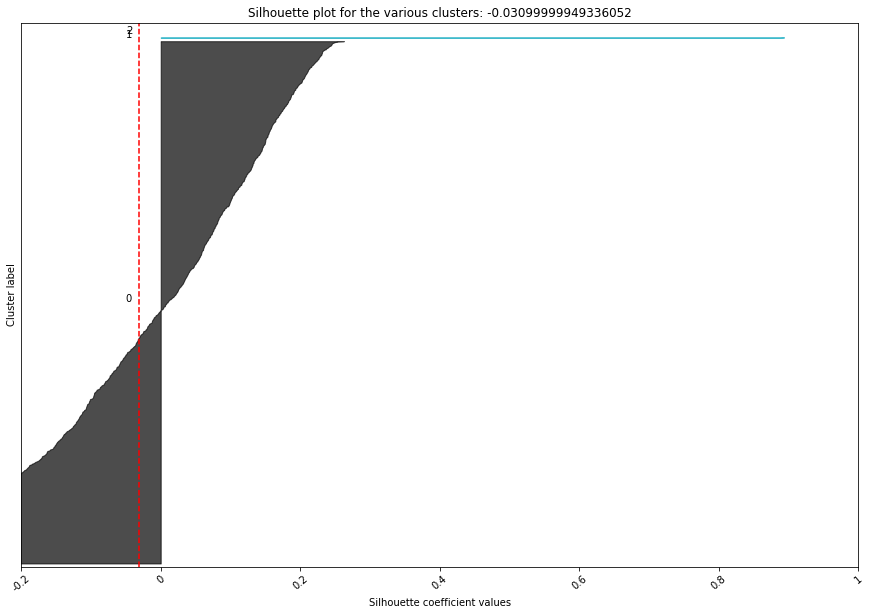

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

n_clusters = len(np.unique(clusters_d2v))
plot_silhouette(X_d2v, n_clusters, clusters_d2v, ax)

plt.show()

---
## Hierarchical clustering

In [8]:
#########################################################################
# Plot a dendogram
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
#########################################################################

from scipy.cluster.hierarchy import dendrogram

# Create linkage matrix and then plot the dendrogram
def plot_dendrogram(model, **kwargs):

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

---

In [ ]:
#########################################################################
# Train data
# Agglomerative clustering
#########################################################################

from sklearn.cluster import AgglomerativeClustering

n_clusters = 30

# Define model
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None) # Compute all tree

clusters_bow = model.fit_predict(X_bow)
# centroid_bow = model.cluster_centers_

clusters_d2v = model.fit_predict(X_d2v)
# centroid_d2v = model.cluster_centers_

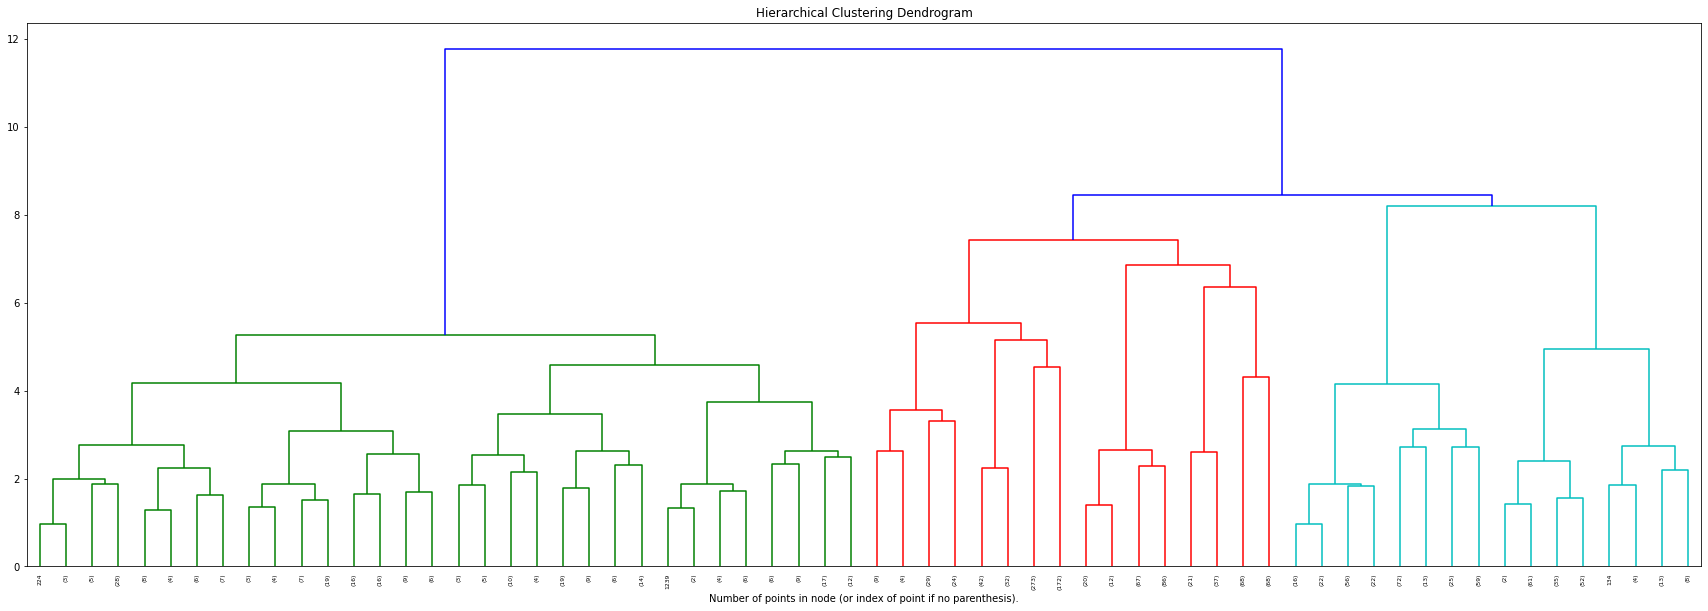

In [ ]:
plt.subplots(1,1,figsize=(30,10))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

---
## HDBSCAN

In [ ]:
!pip install hdbscan
import hdbscan

     |████████████████████████████████| 6.4 MB 13.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311870 sha256=f2593e4a336089fdf0883cefd2369f70dca700f0d5263bab83e04b0fd12f149b
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [ ]:
model_hdbscan = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
model_hdbscan.fit(X_d2v)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=1, p=None,
        prediction_data=False)

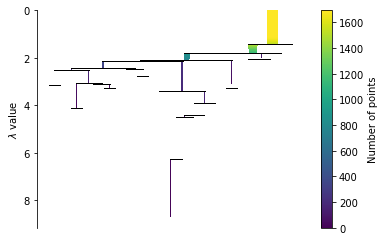

In [ ]:
model_hdbscan.condensed_tree_.plot()

In [ ]:
clusters_hdbscan = model_hdbscan.labels_

print("Mean Silhouette Coefficient [D2V]: %0.3f" % silhouette_score(X_d2v, clusters_hdbscan))
print(np.unique(clusters_hdbscan))

Mean Silhouette Coefficient [D2V]: -0.036
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]


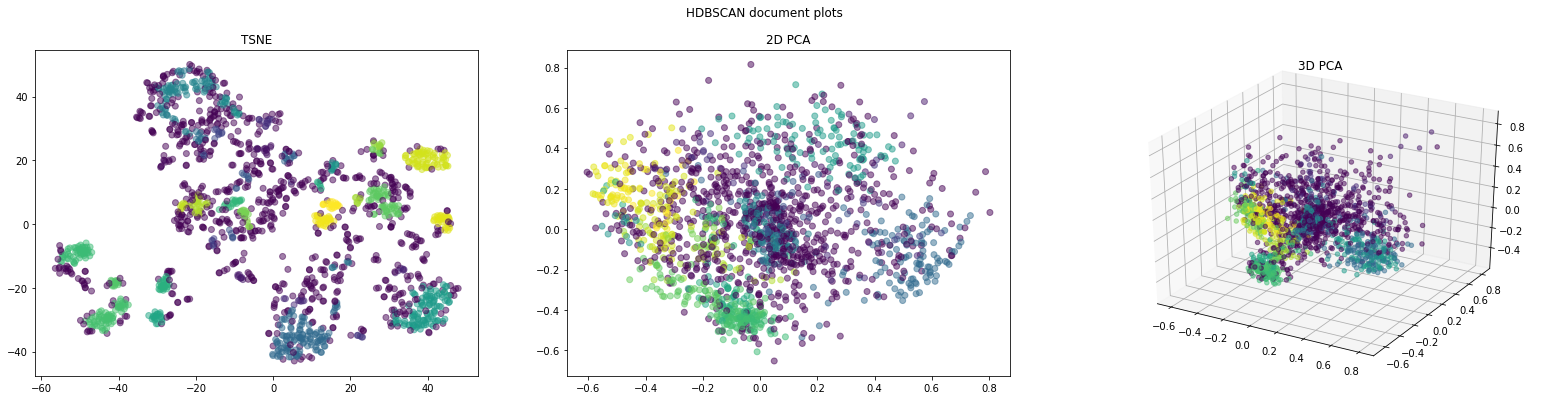

In [ ]:
visualize_data(X_d2v, "HDBSCAN", clusters_hdbscan)

---
## OPTICS

In [ ]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=10)

clusters_optics = optics.fit_predict(X_d2v)

In [ ]:
print("Mean Silhouette Coefficient [D2V]: %0.3f" % silhouette_score(X_d2v, clusters_optics))
print(np.unique(clusters_optics))

Mean Silhouette Coefficient [D2V]: -0.202
[-1  0  1  2  3  4  5  6  7  8  9]


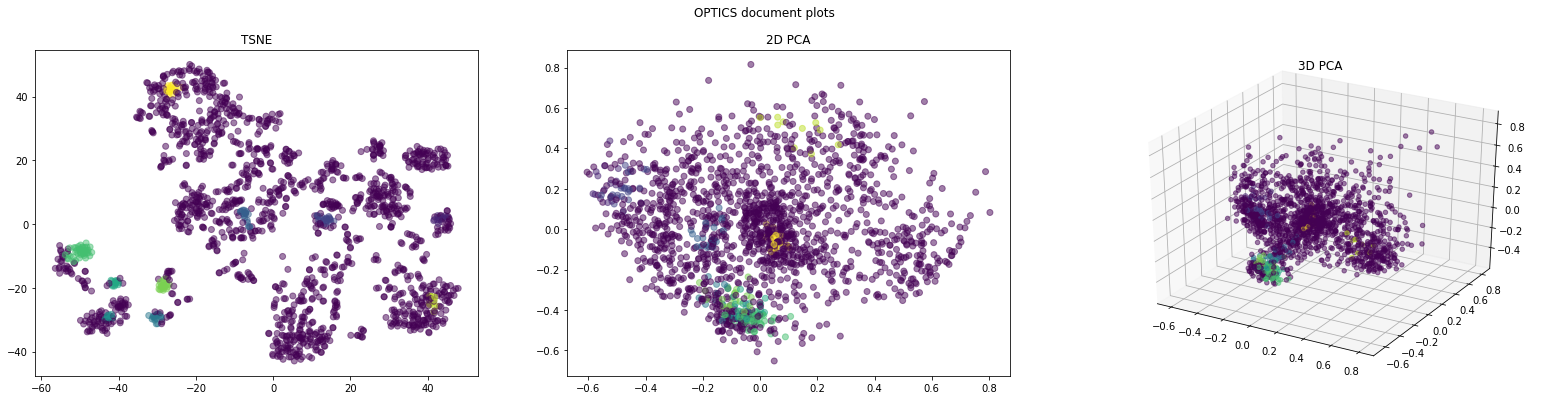

In [ ]:
visualize_data(X_d2v, "OPTICS", clusters_optics)

As with DBSCAN, too many points are considered noise.
It seems clear that density based methods will not work with this data **as it is**, because it appears there is not a clear structure in the space.

---

## LDA

**The problem with LDA is that it gives the topic as a WORD, not a sequence**

But we could try to take the top_n topics for a document, decode them as a sequence and see if together they make sense as a cluster.

In [24]:
#########################################################################
# Train data
# Latent Dirichlet Allocation (LDA)
# https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
# https://radimrehurek.com/gensim/models/ldaseqmodel.html
#########################################################################

# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Set training parameters.
num_topics = 16
chunksize = len(corpus_lists)
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

# Set callbacks
# https://www.meganstodel.com/posts/callbacks/
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
convergence_logger = ConvergenceMetric(logger='shell')
# coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'c_v', texts = documents) # c_v vs u_mass ??
coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'u_mass')

lda = LdaModel(
    corpus=corpus_bow,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    callbacks=[convergence_logger, perplexity_logger, coherence_cv_logger],
    random_state=12345
)

In [25]:
top_topics = lda.top_topics(corpus, topn=10)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
# The smallest (considering negative) the better (or the bigger if ignoring the sign)
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

top_topics

Average topic coherence: -3.1137.


[([(0.31866685, '1-0-2-3-0-1'),
   (0.16884206, '3-0-2-3-0-1'),
   (0.14502417, '0-0-2-3-2-1'),
   (0.10977488, '0-0-2-3-1-1'),
   (0.035815056, '1-0-0-1-0-1'),
   (0.035086893, '0-0-0-1-3-1'),
   (0.035086006, '0-0-0-2-4-1'),
   (0.032623556, '1-0-0-2-0-1'),
   (0.020984132, '0-0-3-1-3-1'),
   (0.017511575, '1-0-3-1-0-1')],
  -0.2931660647916775),
 ([(0.19404529, '1-0-2-1-0-1'),
   (0.1427227, '3-0-2-1-0-1'),
   (0.086792044, '1-0-3-2-0-1'),
   (0.070595436, '0-0-2-1-1-1'),
   (0.06603974, '3-0-3-2-0-1'),
   (0.058081295, '1-0-2-2-0-1'),
   (0.05740693, '0-0-2-1-3-1'),
   (0.05740691, '0-0-2-2-4-1'),
   (0.047130316, '0-0-3-1-3-1'),
   (0.037926953, '1-0-3-1-0-1')],
  -0.47936753530871573),
 ([(0.11634866, '1-0-3-1-0-1'),
   (0.10500367, '1-0-3-2-0-1'),
   (0.07829391, '3-0-3-1-0-1'),
   (0.070051074, '1-0-0-1-0-1'),
   (0.06625405, '1-0-0-2-0-1'),
   (0.06356534, '3-0-3-2-0-1'),
   (0.051722717, '0-0-3-1-3-1'),
   (0.04986266, '3-0-0-1-0-1'),
   (0.04410042, '0-0-3-2-1-1'),
   (0.038

In [ ]:
lda.print_topics()

[(0,
  '0.129*"1-2-1-0-0-0" + 0.111*"1-2-1-3-0-0" + 0.091*"1-2-1-1-0-0" + 0.085*"1-2-1-2-0-0" + 0.075*"3-2-1-0-0-0" + 0.061*"0-2-1-0-12-0" + 0.059*"3-2-1-3-0-0" + 0.049*"0-2-1-2-4-0" + 0.049*"0-2-1-1-3-0" + 0.048*"3-2-1-1-0-0"'),
 (1,
  '0.146*"1-0-0-3-0-1" + 0.113*"1-0-2-2-0-1" + 0.082*"1-0-3-3-0-1" + 0.078*"3-0-0-3-0-1" + 0.077*"1-0-2-1-0-1" + 0.074*"0-0-0-3-2-1" + 0.057*"3-0-2-2-0-1" + 0.056*"0-0-2-2-4-1" + 0.056*"0-0-2-1-3-1" + 0.043*"3-0-3-3-0-1"'),
 (2,
  '0.195*"1-1-0-1-0-1" + 0.166*"1-1-0-2-0-1" + 0.127*"3-1-0-1-0-1" + 0.088*"3-1-0-2-0-1" + 0.088*"0-1-0-1-3-1" + 0.086*"0-1-0-2-4-1" + 0.080*"0-1-0-1-1-1" + 0.054*"0-1-0-2-1-1" + 0.029*"1-1-2-3-0-1" + 0.018*"0-1-2-3-5-1"'),
 (3,
  '0.202*"1-1-4-2-0-1" + 0.193*"1-1-4-1-0-1" + 0.130*"3-1-4-2-0-1" + 0.114*"3-1-4-1-0-1" + 0.088*"0-1-4-1-3-1" + 0.083*"0-1-4-2-1-1" + 0.080*"0-1-4-1-1-1" + 0.018*"2-1-4-2-9-1" + 0.018*"0-1-4-2-5-1" + 0.017*"0-1-4-2-7-1"'),
 (4,
  '0.116*"1-0-3-1-0-1" + 0.105*"1-0-3-2-0-1" + 0.078*"3-0-3-1-0-1" + 0.070*"1-

In [ ]:
#########################################################################
# Get 10 topics for each document (day)
# SEE
# https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc
#########################################################################

# Return topics with probability higher than @prob in descending order
def get_top_topics(topic_list, prob=0.3):
  # Sort by probabilities
  topic_list.sort(key=lambda x: x[1], reverse=True)

  topics = []
  for t in topic_list:
    if t[1] > prob:
      topics.append(t[0])

  return topics

# ------------------------------------------------------------------------------

# Get LDA topic list for each driver day
def get_topics(corpus):
  df_topics = []

  # Getting a list of [driver, day]
  for name, group in df.groupby(["Driver","Day"], sort=False): # False to keep driver ordering
    df_topics.append([name[0], int(name[1])])

  # Getting the topics for each document
  topic_lists = [lda.get_document_topics(item) for item in corpus]

  # Ignore probabilities and keep only topics number
  doc_topics = [get_top_topics(tl) for tl in topic_lists]

  # Add topics to each [driver,day]
  for row, topics in zip(df_topics, doc_topics):
    row.append(topics)

  return pd.DataFrame(df_topics, columns=["Driver", "Day", "Topic list"])

In [ ]:
df_driver_topics = get_topics(corpus)
df_driver_topics

,Driver,Day,Topic list
0,driver1,1,[2]
1,driver1,2,[12]
2,driver1,3,[11]
3,driver1,4,[4]
4,driver1,5,[2]
...,...,...,...
1689,driver188,8,"[8, 5]"
1690,driver188,9,[2]
1691,driver188,10,"[3, 14]"
1692,driver188,11,[12]


In [26]:
#########################################################################
# Get decoded topics for LDA
#########################################################################

# Get list of topics (each one is a list of activities)
aux = [t[0] for t in top_topics]

topic_list = []
for t in aux:
  topic_list.append([x[1] for x in t])

decoded_topics = []
# Decode topics
for topic in topic_list:
  decoded_t = v_undo_encoding(topic)
  orig_t = ordinalencoder_X.inverse_transform(decoded_t)
  decoded_topics.append(orig_t)

cols = ['Activity', 'DayType', 'Sequence', 'BreakType', 'Token', 'Legal']

df_centroids = pd.DataFrame(columns=cols)

for c, number in zip(decoded_topics, range(len(decoded_topics))):
  df_c = pd.DataFrame(c, columns=cols)
  df_c["Topic"] = number

  df_centroids = df_centroids.append(df_c)

# Set decoded topics as a dictionary
decoded_topics = {}
for name, group in df_centroids.groupby("Topic"):
  decoded_topics[name] = group

decoded_topics

{0.0:   Activity DayType Sequence      BreakType Token Legal  Topic
 0  Driving     edd   second  uninterrupted     A     1    0.0
 1    Other     edd   second  uninterrupted     A     1    0.0
 2    Break     edd   second  uninterrupted  B_T1     1    0.0
 3    Break     edd   second  uninterrupted  B_T0     1    0.0
 4  Driving     edd    first        split_1     A     1    0.0
 5    Break     edd    first        split_1  B_T2     1    0.0
 6    Break     edd    first        split_2  B_T3     1    0.0
 7  Driving     edd    first        split_2     A     1    0.0
 8    Break     edd    third        split_1  B_T2     1    0.0
 9  Driving     edd    third        split_1     A     1    0.0,
 1.0:   Activity DayType Sequence BreakType Token Legal  Topic
 0  Driving     edd   second   split_1     A     1    1.0
 1    Other     edd   second   split_1     A     1    1.0
 2  Driving     edd    third   split_2     A     1    1.0
 3    Break     edd   second   split_1  B_T0     1    1.0
 4    

LDA is not properly trained, but at this point I can see that topics are not fully interpretable. The activities by itself seems coherent, but not the order in which are displayed (this is due to the coherence value of each topic)

In [ ]:
#########################################################################
# Save results
#########################################################################

!mkdir results

# Save topics
for name, group in df_centroids.groupby("Topic"):
  group.to_csv("results/topic{}.csv".format(int(name)), sep="\t", index=False)

df_driver_topics.to_csv("results/driver_topics.csv", sep="\t", index=False)

mkdir: cannot create directory ‘results’: File exists


---
## Download results

In [186]:
# Delete previous results
!rm -r results
!rm results.zip

In [189]:
# Zip and download
!zip -r results.zip results

files.download("results.zip")

  adding: results/ (stored 0%)
  adding: results/log-clustering-c17.csv (deflated 88%)
  adding: results/log-clustering-c21.csv (deflated 88%)
  adding: results/log-clustering-c19.csv (deflated 82%)
  adding: results/log-clustering-c4.csv (deflated 88%)
  adding: results/log-clustering.csv (deflated 88%)
  adding: results/log-clustering-c14.csv (deflated 88%)
  adding: results/log-clustering-c6.csv (deflated 88%)
  adding: results/log-clustering-c7.csv (deflated 89%)
  adding: results/log-clustering-c23.csv (deflated 88%)
  adding: results/log-clustering-c22.csv (deflated 82%)
  adding: results/log-clustering-c11.csv (deflated 88%)
  adding: results/log-clustering-c13.csv (deflated 88%)
  adding: results/log-clustering-c8.csv (deflated 88%)
  adding: results/log-clustering-c24.csv (deflated 88%)
  adding: results/log-clustering-c20.csv (deflated 88%)
  adding: results/log-clustering-c1.csv (deflated 85%)
  adding: results/log-clustering-c2.csv (deflated 88%)
  adding: results/log-clust

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>